In [1]:
import earthkit as ek
import cdsapi

In [2]:
client = cdsapi.Client()

2024-12-15 10:47:40,293 INFO [2024-09-26T00:00:00] **Welcome to the New Atmosphere Data Store (ADS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new ADS for the benefit of everyone. Thank you.
2024-12-15 10:47:40,293 INFO [2024-09-26T00:00:00] Watch our [Forum]( https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


# Descargar datos

#### Contaminación

In [4]:
dataset = "cams-global-greenhouse-gas-inversion"
request = {
    "variable": "carbon_dioxide",
    "quantity": "concentration",
    "input_observations": "satellite",
    "time_aggregation": "instantaneous",
    "version": "latest",
    "year": ["2021"],
    "month": [
        "01", "02", "03",
        "04"
    ]
}

client.retrieve(dataset, request).download('./input/data.zip')

2024-12-15 11:01:51,834 INFO Request ID is 9cffb893-7dfa-4a5c-9eb8-6b53732b295e
2024-12-15 11:01:52,158 INFO status has been updated to accepted
2024-12-15 11:01:58,293 INFO status has been updated to running
2024-12-15 11:12:21,101 INFO status has been updated to successful


d790b27c976bb561d9432589466906e5.zip:   0%|          | 0.00/9.63G [00:00<?, ?B/s]

'd790b27c976bb561d9432589466906e5.zip'

#### Variables climáticas

In [ ]:
dataset = "reanalysis-era5-single-levels"
request = {
    "product_type": ["reanalysis"],
    "variable": [
        "10m_u_component_of_wind",
        "10m_v_component_of_wind",
        "mean_sea_level_pressure",
        "sea_surface_temperature",
        "surface_pressure",
        "total_precipitation",
        "100m_u_component_of_wind",
        "100m_v_component_of_wind",
        "10m_u_component_of_neutral_wind",
        "10m_v_component_of_neutral_wind"
    ],
    "year": ["2021"],
    "month": ["03"],
    "day": [
        "01", "02", "03",
        "04"
    ],
    "time": [
        "00:00", "01:00", "02:00",
        "03:00", "04:00", "05:00",
        "06:00", "07:00", "08:00",
        "09:00", "10:00", "11:00",
        "12:00", "13:00", "14:00",
        "15:00", "16:00", "17:00",
        "18:00", "19:00", "20:00",
        "21:00", "22:00", "23:00"
    ],
    "data_format": "grib",
    "download_format": "unarchived"
}

client.retrieve(dataset, request).download()

# Trabajar con los datos

In [1]:
import os
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.animation as animation

In [2]:
files = os.listdir('./input/data/')

In [3]:
path = './input/data/' + files[1]
ds = nc.Dataset(path, 'r')
ds.variables.keys()

In [4]:
CO2 = ds.variables['CO2']
lon = ds.variables['Mesh_face_lon'][:]
lat = ds.variables['Mesh_face_lat'][:]

In [5]:
CO2.dimensions

('time', 'level', 'nMeshface')

In [7]:
CO2_relevante = CO2[:, :79, :]
CO2_promedio = np.mean(CO2_relevante, axis=(1))
CO2_promedio.shape

(248, 64002)

In [8]:
time = ds.variables['time']
time_units = time.units 
time_calendar = getattr(time, 'calendar', 'gregorian')
time_steps = nc.num2date(time[:], units=time_units, calendar=time_calendar)

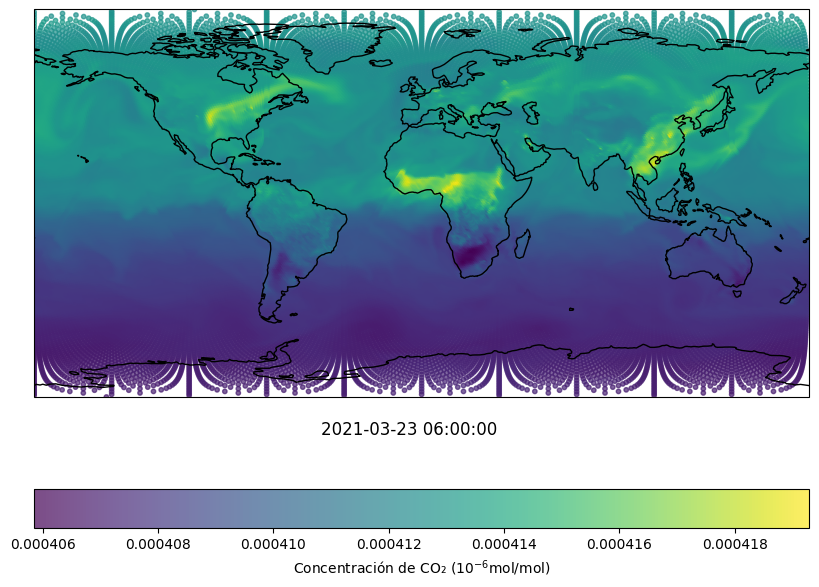

In [9]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=100, subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()

sc = ax.scatter(lon, lat, c=CO2_promedio[178, :], cmap='viridis', s=10, transform=ccrs.PlateCarree(), alpha=0.7)

#ax.set_title(f'CO₂ Promedio  {time_steps[178]}', fontsize=16)
cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', label= r'Concentración de CO₂ ($10^{-6}$mol/mol)')
fig.text(0.5, 0.3, f'{time_steps[178]}', ha='center', va='center', fontsize=12)

plt.show()

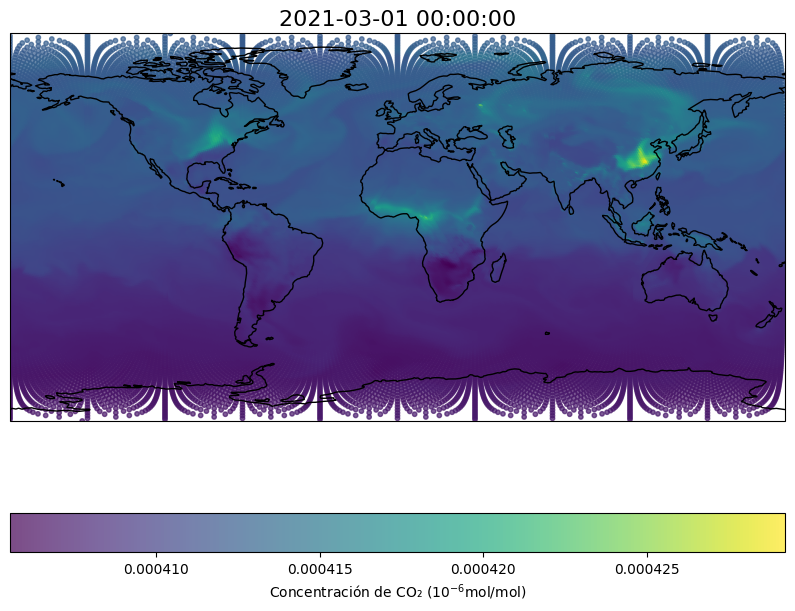

In [11]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=100, subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()

sc = ax.scatter(lon, lat, c=CO2_promedio[0, :], cmap='viridis', s=10, transform=ccrs.PlateCarree(), alpha=0.7)
cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', label= r'Concentración de CO₂ ($10^{-6}$mol/mol)')

def update(frame):
    sc.set_offsets(np.c_[lon, lat])  
    sc.set_array(CO2_promedio[frame, :]) 
    ax.set_title(f'{time_steps[frame]}', fontsize=16)
    
ani = animation.FuncAnimation(fig, update, frames=len(time_steps), interval=200, repeat=False)

ani.save('CO2_animation.gif', writer='pillow', fps=10)

In [98]:
from opencage.geocoder import OpenCageGeocode
import searoute as sr
import pandas as pd
import json
import requests
import random

In [16]:
key = ''
geocoder = OpenCageGeocode(key)

In [93]:
ports = [
    "Suez Canal", "Rotterdam", "Antwerp-Bruges", "Novorossiysk", "Hamburg"
    "Ust-Luga", "Algeciras", "Constanța", "HAROPA", "Gdańsk", "Valencia",
    "Marseille", "Bergen", "Barcelona", "Genoa", "Primorsk", "Amsterdam",
    "Murmansk", "Trieste", "London", "Immingham", "Saint Petersburg"
]

puertos = pd.DataFrame(columns=["Port", "Latitude", "Longitude"])
for port in ports:
    result = geocoder.geocode(port)
    if result:
        location = result[0]['geometry']
        row = {"Port": port, "Latitude": location['lat'], "Longitude": location['lng']}
        puertos = pd.concat([puertos, pd.DataFrame([row])], ignore_index= True)

C:\Users\HP\AppData\Local\Temp\ipykernel_2344\3498569443.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  puertos = pd.concat([puertos, pd.DataFrame([row])], ignore_index= True)


In [115]:
european_ports = [[lat, lon] for _, (_, lat, lon) in puertos.iloc[1:].iterrows()]
suez_entry = [30.6052767, 32.3331003]

In [116]:
for i , port in enumerate(european_ports):
    try:
        route = sr.searoute(
            suez_entry, 
            port, 
            restrictions=['suez']
            )
        route_coords = route.geometry.coordinates
    except Exception as e:
        print(f"{european_ports[i]}")
        continue

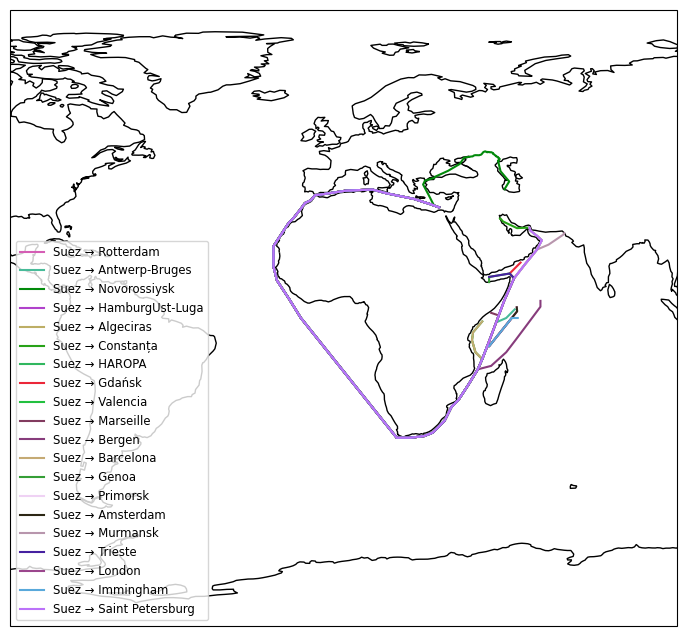

In [119]:
fig, ax = plt.subplots(figsize=(12, 8), dpi=100, subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-95, 100, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()

def random_color():
    return [random.random(), random.random(), random.random()]

for i, port in enumerate(european_ports):
    try:
        route = sr.searoute(suez_entry, port, restrictions=['suez'])
        route_coords = route.geometry.coordinates  
        longitudes, latitudes = zip(*route_coords)
        

        ax.plot(longitudes, latitudes, color=random_color(), transform=ccrs.PlateCarree(),
                label=f"Suez → {ports[i+1]}") 

    except Exception as e:
        print(f"Error con el puerto {port}: {e}")
        continue

plt.legend(loc='lower left', fontsize='small')
plt.show()


In [54]:
headers = {
    "accept": "application/json",
    "x-api-key": ""
}

In [95]:
lat_or = 25
lon_or = 35
routes_data = []
origin = "Suez"
for _, (destination, lat_des, lon_des) in puertos[1:].iterrows():
    url = f"https://api.searoutes.com/route/v2/sea/{lon_or}%2C{lat_or}%3B{lon_des}%2C{lat_des}?continuousCoordinates=true&allowIceAreas=false&avoidHRA=false&avoidSeca=false&blockAreas=11117"
    response = requests.get(url, headers=headers)
    data = json.loads(response.text)
    try:
        features = data["features"]
        for feature in features:
            geometry = feature["geometry"]
            properties = feature["properties"]
            distance = properties.get("distance")
            mode = properties.get("mode")
            departure = properties.get("departure")
            arrival = properties.get("arrival")
            duration = properties.get("duration")
            ice = properties.get("intersectsIceArea")
            coords = geometry.get("coordinates")
            lat = [lat for [lat, _] in coords]
            lon = [lon for [_, lon] in coords]
            for i in range(0, len(lat)):
                routes_data.append([origin, destination, distance, mode, departure, arrival, duration, ice, lat[i], lon[i]])
    except Exception as e:
        print(response)
        continue
    
routes_data = pd.DataFrame(routes_data, columns= ['origin', 'destination','distance', 'mode', 'departure', 'arrival' ,'duration', 'intersectsIceArea', 'latitude', 'longitude'])
routes_data.to_csv('input/rutas_alternativas.csv')

<Response [429]>
<Response [404]>
<Response [404]>
